# Table of Contents
 <p><div class="lev1 toc-item"><a href="#plot-NMI-as-beta-varies" data-toc-modified-id="plot-NMI-as-beta-varies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>plot NMI as beta varies</a></div><div class="lev1 toc-item"><a href="#hysteresis-in-modbp" data-toc-modified-id="hysteresis-in-modbp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>hysteresis in modbp</a></div><div class="lev1 toc-item"><a href="#Testing-on-football-network" data-toc-modified-id="Testing-on-football-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing on football network</a></div><div class="lev1 toc-item"><a href="#Test-multilayer-SBM" data-toc-modified-id="Test-multilayer-SBM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test multilayer SBM</a></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
import sklearn.metrics as skm
# reload(modbp)

[(0, 105), (0, 188), (0, 347), (0, 376), (1, 186)]
niters to converge 28
[[0.06458066 0.93541934]
 [0.08140313 0.91859687]
 [0.20646308 0.79353692]
 [0.76179636 0.23820364]
 [0.25027316 0.74972684]
 [0.5        0.5       ]
 [0.29491933 0.70508067]
 [0.31014254 0.68985746]
 [0.10158471 0.89841529]
 [0.20448821 0.79551179]]
modularity igraph: 0.434754
AMI: 0.547
accuracy: 0.097
percent: 0.097


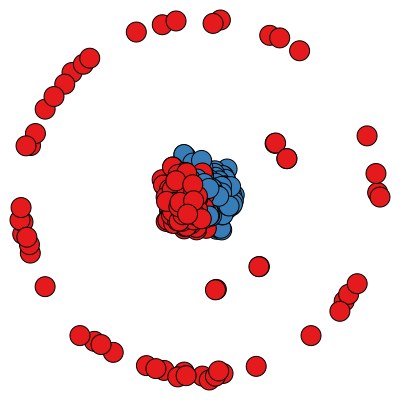

In [9]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
t=time()
prob_mat=np.identity(nblocks)*pin + (np.ones((nblocks,nblocks))-np.identity(nblocks))*pout

read=True
if read:
    RSBM=modbp.RandomSBMGraph(n,prob_mat,graph=ig.load('RSMB_test.graphml.gz'))
else:
    RSBM = modbp.RandomSBMGraph(n=n,comm_prob_mat=prob_mat)
    RSBM.graph.save('RSMB_test.graphml.gz')

color_dict=dict(zip(range(10),sbn.color_palette('Set1',10)))
# RSBM.graph.vs['color']=map(lambda x : color_dict[x],RSBM.graph.vs['block'])

elist=RSBM.get_edgelist()
elist.sort()
print elist[:5]

pv=modbp.bp.PairVector(elist)
bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=1.3, transform=False)
print 'niters to converge',bpgc.run(1000)
marg=np.array(bpgc.return_marginals())
print marg[:10]
part=np.argmax(marg,axis=1)
VC=ig.VertexClustering(RSBM.graph,membership=part)
# print "modularity: {:.6f}".format(mbpinterface.retrival_modularities[q][beta])
print "modularity igraph: {:.6f}".format(VC.modularity)
print "AMI: {:.3f}".format(RSBM.get_AMI_with_blocks(labels=part))
print "accuracy: {:.3f}".format(RSBM.get_accuracy(labels=part))
print "percent: {:.3f}".format(np.sum(RSBM.block==part)/(1.0*n))

RSBM.graph.vs['color']=map(lambda x : color_dict[x] ,np.argmax(marg,axis=1))
#create forceatlas layout
adj=np.array(RSBM.get_adjacency())
pos=fa2.forceatlas2(adj,scalingRatio=10,gravity=1,strongGravityMode=False,edgeWeightInfluence=0)
layout=ig.Layout(pos)
ig.plot(RSBM.graph,layout=layout,inline=True,bbox=[400,400])

# plot NMI as beta varies

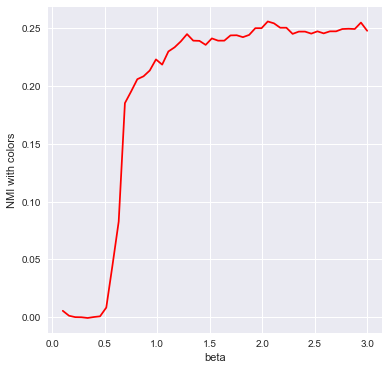

In [50]:
betas=np.linspace(.1,3,50)
fin_nmi=[]
for beta in betas:
    #This is where we would want to be able to recall the BP algorithm
    #without having to reconstruct the graph.  Presumably we could use 
    #the state of previous BP as warm initialization
    bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
    bpgc.run()
    marg=np.array(bpgc.return_marginals())
    color_dict={0:"red",1:"blue",2:'green'}
    RSBM.graph.vs['color']=map(lambda x : color_dict[np.argmax(x)],marg)
    cnmi=RSBM.get_AMI_with_blocks(RSBM.graph.vs['color'])
#     print("NMI at beta={:.2f}: {:.3f}".format(beta,cnmi))
    fin_nmi.append(cnmi)

fin_nmi=np.array(fin_nmi)
plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))
a.plot(betas,fin_nmi,color='r')
a.set_xlabel('beta')
a.set_ylabel('NMI with colors')
plt.show()

In [2]:
n = 1000
q = 2
nblocks = q
c = 3.0
ep = .1
pin = c / (1.0 + ep) / (n * 1.0 / q)
pout = c / (1 + 1.0 / ep) / (n * 1.0 / q)
prob_mat = np.identity(nblocks) * pin + (np.ones((nblocks, nblocks)) - np.identity(nblocks)) * pout
read = True
if read:
    print 'loading graph from file'
    RSBM = modbp.RandomSBMGraph(n, prob_mat, graph=ig.load('RSMB_test.graphml.gz'))
    print ("{:d},{:d}".format(RSBM.n,RSBM.m))
else:
    RSBM = modbp.RandomSBMGraph(n=n, comm_prob_mat=prob_mat,transform=False)
    RSBM.graph.save('RSMB_test.graphml.gz')

beta=1.5
#call directly
elist = RSBM.get_edgelist()
elist.sort()
pv = modbp.bp.PairVector(elist)
bpgc = modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
print ('niters to converge', bpgc.run(1000))
marg = np.array(bpgc.return_marginals())
print (marg[:5])
part=np.argmax(marg,axis=1)
print ("modularity: {:.4f} ".format(ig.VertexClustering(RSBM.graph,membership=part).modularity))
print ("AMI: {:.3f}".format(RSBM.get_AMI_with_blocks(labels=part)))
print ("accuracy: {:.3f}".format(np.sum(RSBM.block == part) / (1.0 * n)))

#test it with the calss method
mbpinterface = modbp.ModularityBP(RSBM.graph)  # create class
mbpinterface.run_modbp(beta,2,1000)
print mbpinterface.marginals[2][beta][:5]
print ('niters to converge',mbpinterface.niters[2][beta])
print ('modularity: {:.4f}'.format(mbpinterface.retrival_modularities[2][beta]))
print part[:20]
print mbpinterface.partitions[2][beta][:20]
print "AMI two partitions {:.3f}".format(skm.adjusted_mutual_info_score(part,mbpinterface.partitions[2][beta]))
# print 'AMI=',RSBM.get_AMI_with_blocks(mbpinterface.partitions[2][beta])
# print "accuracy=",RSBM.get_accuracy(mbpinterface.partitions[2][beta])

loading graph from file
1000,1502
('niters to converge', 30)
[[0.02786616 0.97213384]
 [0.05291597 0.94708403]
 [0.13891308 0.86108692]
 [0.80188059 0.19811941]
 [0.20623338 0.79376662]]
modularity: 0.4354 
AMI: 0.551
accuracy: 0.096
[[0.02786616 0.97213384]
 [0.05291597 0.94708403]
 [0.13891308 0.86108692]
 [0.80188059 0.19811941]
 [0.20623338 0.79376662]]
('niters to converge', 30)
modularity: 0.4354
[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
AMI two partitions 0.829


# elist= randSBM.get_edgelist()
elist.sort()
print elist[:10]
print mbpinterface._edgelistpv

# hysteresis in modbp

In [29]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat
randSBM=modbp.RandomSBMGraph(n,prob_mat)

mbpinterface=modbp.ModularityBP(randSBM.graph)
mbpinterface.run_modbp(q=2,beta=1.2)
mbpinterface.run_modbp(q=2,beta=.2)
mbpinterface.run_modbp(q=2,beta=.1)
mbpinterface.run_modbp(q=2,beta=.01)
print mbpinterface.retrival_modularities
print 
mbpinterface2=modbp.ModularityBP(randSBM.graph)
mbpinterface2.run_modbp(q=2,beta=.01)
mbpinterface2.run_modbp(q=2,beta=.1)
mbpinterface2.run_modbp(q=2,beta=.2)
mbpinterface2.run_modbp(q=2,beta=1.2)
print mbpinterface2.retrival_modularities


[[0.005 0.001]
 [0.001 0.005]]
{2: {0.01: 0.011622524441753233, 1.2: 0.3830931001890359, 0.1: 0.013987319455930965, 0.2: 0.019903922126063348}}

{2: {0.2: 0.08946623198251417, 1.2: 0.3830931001890359, 0.1: -0.012876456536507559, 0.01: -0.04865667274633746}}


[[0.005 0.001]
 [0.001 0.005]]
average degree: 2.948


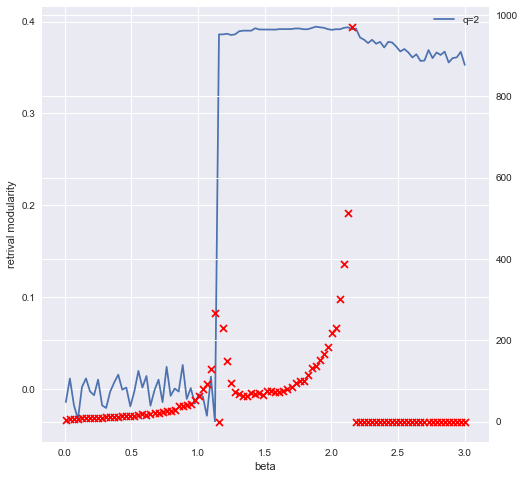

In [3]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep*(q-1.0))/(n*1.0/q)
pout=c/(1+(q-1.0)/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat
randSBM=modbp.RandomSBMGraph(n,prob_mat)
mbpinterface=modbp.ModularityBP(randSBM.graph)

print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
betas=np.linspace(.01,3,100)
# betas=np.array([.1,.5,1,1.2])
qs=np.array([2])#,4,5])

for q in qs:
    for beta in betas:
        mbpinterface.run_modbp(q=q,beta=beta,niter=1000)

plt.close()
f,a=plt.subplots(1,1,figsize=(8,8))

for q in qs:
    b,t=zip(*sorted(mbpinterface.niters[q].items(),key=lambda x: x[0]))
    b,m=zip(*sorted(mbpinterface.retrival_modularities[q].items(),key=lambda x: x[0]))
    a.plot(b,m,label="q={:d}".format(q))
    a2=a.twinx()
    a2.scatter(b,t,marker='x',color='red',label='covergence')


a.set_xlabel("beta")
a.set_ylabel("retrival modularity")
a.legend()
plt.show()


In [ ]:
b=np.array([0, 5, 2, 5, 4, 5])
c=[np.random.choice(np.flatnonzero(b == b.max())) for i in range(1000)]


[[0.0075  0.00075 0.00075 0.00075]
 [0.00075 0.0075  0.00075 0.00075]
 [0.00075 0.00075 0.0075  0.00075]
 [0.00075 0.00075 0.00075 0.0075 ]]
average degree: 2.386


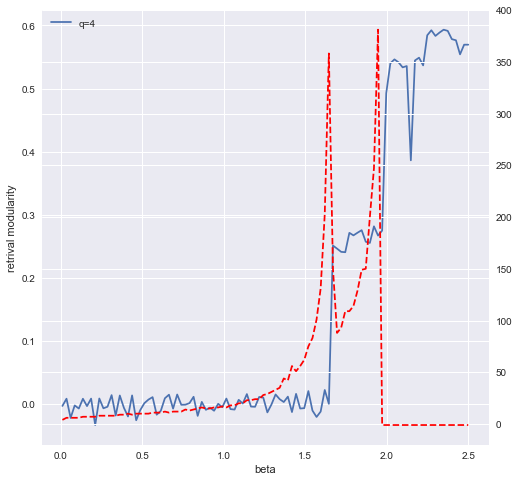

In [8]:
n=1000
q=4
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep*(q-1.0))/(n*1.0/q)
pout=c/(1+(q-1.0)/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat

outgraph="random_test-graph.graphml.gz"
if read=True:
    randSBM=ig.load(outgraph)
else:
    randSBM=modbp.RandomSBMGraph(n,prob_mat)
mbpinterface=modbp.ModularityBP(randSBM.graph)

print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
betas=np.linspace(.01,2.5,50)
# betas=np.array([.1,.5,1,1.2])
qs=np.array([4])#,4,5])

for q in qs:
    for beta in betas:
        mbpinterface.run_modbp(q=q,beta=beta,niter=1000)

plt.close()
f,a=plt.subplots(1,1,figsize=(8,8))

for q in qs:
    b,t=zip(*sorted(mbpinterface.niters[q].items(),key=lambda x: x[0]))
    b,m=zip(*sorted(mbpinterface.retrival_modularities[q].items(),key=lambda x: x[0]))
    a.plot(b,m,label="q={:d}".format(q))
    a2=a.twinx()
#     a2.scatter(b,t,marker='x',color='red',label='covergence')
    a2.plot(b,t,linestyle='--',color='red',label='covergence')


a.set_xlabel("beta")
a.set_ylabel("retrival modularity")
a.legend()
plt.show()


# Testing on football network
We scan to look at how many communities are suggested

In [7]:
fbnet=ig.load("./football.net.graphml.gz")
n=fbnet.vcount()
elist=fbnet.get_edgelist()
elist.sort()
pv=modbp.bp.PairVector(elist)

betas=np.linspace(.5,2,30)
qs=np.linspace(2,20)
mbpinter=modbp.ModularityBp(fbnet)



print("time to construct {:.4f}".format(time()-t))

AttributeError: 'module' object has no attribute 'ModularityBp'

In [21]:
np.array(np.array(ml_sbm.layer_sbms[0].get_adjacency().data))

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

# Test multilayer SBM

time to create 30 nodes and 3 layers : 0.00282


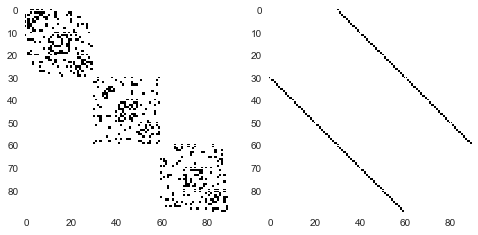

In [13]:
np.random.seed(1)
n = 30
nlayers=3
q = 3
nblocks = q
c = 5.0
ep = .2
pin = c / (1.0 + ep) / (n * 1.0 / q)
pout = c / (1 + 1.0 / ep) / (n * 1.0 / q)
prob_mat = np.identity(nblocks) * pin + (np.ones((nblocks, nblocks)) - np.identity(nblocks)) * pout
t=time()
ml_sbm=modbp.MultilayerSBM(n,comm_prob_mat=prob_mat,layers=nlayers,transition_prob=.1)
print( "time to create {:d} nodes and {:d} layers : {:.5f}".format(n,nlayers,time()-t))



plt.close()
f,a=plt.subplots(1,2,figsize=(8,4))
a=plt.subplot(1,2,1)
plt.imshow(ml_sbm.get_intralayer_adj())
a=plt.subplot(1,2,2)
plt.imshow(ml_sbm.get_interlayer_adj())
plt.show()

In [10]:
x=np.array([1,2,3,4,5])
# x[[0,1,2]]+=1
inds,cnts=np.unique([0,0,0],return_counts=True)
x[inds]+=-1*cnts
print(x)

[-2  2  3  4  5]
